In [1]:
import copy
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import colors
from itertools import cycle, product
from bokeh.palettes import Category20_20 as categ20c
from bokeh.palettes import Set3_12 as set3c
from bokeh.palettes import Dark2_8 as dark2c

%matplotlib inline

In [2]:
CURR_PATH = pathlib.Path().parent
MPLSTYLE = CURR_PATH.joinpath("plotstyle.mplstyle")
plt.style.use(MPLSTYLE)

In [3]:
MARKERS = ["s", "o", "H", "p", "*", "h", "s", "X"]

In [4]:
M_PROTON = 0.938272
M_NEUTRON = 0.93957
M_N = ((M_PROTON + M_NEUTRON) / 2)**2

In [5]:
default_order = ['x', 'Q2', 'Exp', 'W2', 'Nev']

In [6]:
MIN_NB_EVENT = 10

In [7]:
def read_txt_pd(
    experiment: str = "FASERv2",
    otype: str = "inclusive",
    charge: str = "nu",
) -> pd.DataFrame:

    main_folder = otype.upper()
    filename = f"clipped_nan_binned_sysevents_{experiment}_{otype}_{charge}.txt"
    path = f"{main_folder}/{experiment}/clipped_nan/{filename}"
    fpath = CURR_PATH.joinpath(f"{path}")
    
    colnames = [
        "x_lower", 
        "x_upper", 
        "x_avg", 
        "Q2_lower", 
        "Q2_upper", 
        "Q2_avg", 
        "E_nu_lower", 
        "E_nu_upper", 
        "E_nu_avg", 
        "d^sigma/dxdQ2", 
        "N_events", 
        "N_events_errs", 
        "N_sys_errs", 
        "Percent_error_theta", 
        "Percent_error_Elepton", 
        "Percent_error_Ehadron", 
        "MC_Samples",
    ]
    
    return pd.read_csv(fpath, skiprows=2, delim_whitespace=True, names=colnames)

In [8]:
def combine_fpf_tables() -> pd.DataFrame:
    otypes = ["inclusive", "charm"]
    experiments = ["FASERv", "FASERv2", "FLArE100", "SND", "AdvSND"]
    charges = ["nu", "nub", "nochargediscrimination"]
    
    combined_tables= []
    for otype, exp, charge in product(otypes, experiments, charges):
        df = read_txt_pd(exp, otype, charge)
        df["exp"] = [exp] * len(df)
        df["otype"] = [otype] * len(df)
        df["charge"] = [charge] * len(df)
        
        combined_tables.append(df)
    
    df_combined = pd.concat(combined_tables, ignore_index=True)

    return df_combined

In [9]:
fpf_predictions = combine_fpf_tables()

In [10]:
def restructure_fpf_tables(df_fpf: pd.DataFrame, min_nb_events: float = 30) -> pd.DataFrame:
    fpf_new = pd.DataFrame()
    
    xx = df_fpf["x_avg"].astype(float, errors="raise")
    q2 = df_fpf["Q2_avg"].astype(float, errors="raise")
    fpf_new["x"] = xx
    fpf_new["Q2"] = q2
    
    fpf_new["Exp"] = df_fpf["exp"]
    fpf_new["W2"] = q2 * (1.0 - xx) / xx + M_N
    fpf_new["Nev"] = df_fpf["N_events"].astype(float, errors="raise")
    
    # Select Events that are not zero
    fpf_new = fpf_new[fpf_new["Nev"] >= min_nb_events]
    
    return fpf_new[default_order]

In [11]:
formatted_fpf = restructure_fpf_tables(fpf_predictions, min_nb_events=MIN_NB_EVENT)
formatted_fpf

,x,Q2,Exp,W2,Nev
0,0.019179,28.42957,FASERv,1454.785480,12.84655
1,0.026318,31.72100,FASERv,1174.446794,19.93007
2,0.036126,35.31052,FASERv,942.988097,28.55651
3,0.049495,37.96873,FASERv,730.029336,38.12044
4,0.067579,42.62532,FASERv,588.999973,43.19656
...,...,...,...,...,...
768,0.175876,214.89850,AdvSND,1007.860228,144.30740
769,0.238645,46.89887,AdvSND,150.504024,222.17510
770,0.240424,241.95920,AdvSND,765.309851,158.11000
771,0.322998,49.79545,AdvSND,105.252414,143.69430


In [12]:
def apply_kinematic_cuts(
    df_table: pd.DataFrame,
    q2_cut: float,
    w2_cut: float,
    x_cut: list = [0, 1],
) -> pd.DataFrame:
    
    df_table = df_table[df_table["x"] > x_cut[0]]
    df_table = df_table[df_table["x"] <= x_cut[1]]
    
    if q2_cut is not None:
        df_table = df_table[df_table["Q2"] >= q2_cut]
        
    if w2_cut is not None:
        df_table = df_table[df_table["W2"] >= w2_cut]
        
    return df_table.reset_index(drop=True)

In [13]:
kinematic_cuts = apply_kinematic_cuts(formatted_fpf, q2_cut=None, w2_cut=None)
kinematic_cuts

,x,Q2,Exp,W2,Nev
0,0.019179,28.42957,FASERv,1454.785480,12.84655
1,0.026318,31.72100,FASERv,1174.446794,19.93007
2,0.036126,35.31052,FASERv,942.988097,28.55651
3,0.049495,37.96873,FASERv,730.029336,38.12044
4,0.067579,42.62532,FASERv,588.999973,43.19656
...,...,...,...,...,...
622,0.175876,214.89850,AdvSND,1007.860228,144.30740
623,0.238645,46.89887,AdvSND,150.504024,222.17510
624,0.240424,241.95920,AdvSND,765.309851,158.11000
625,0.322998,49.79545,AdvSND,105.252414,143.69430


In [14]:
max_nevents = kinematic_cuts["Nev"].max()
max_nevents

23539.65

In [15]:
def group_by_experiment(df_table: pd.DataFrame) -> dict:
    process = df_table["Exp"].unique().tolist()
    
    collect_process = {}
    for pr in process:
        df_proc = df_table.loc[df_table["Exp"] == pr]
        xx = df_proc["x"].to_numpy()
        q2 = df_proc["Q2"].to_numpy()
        nev = df_proc["Nev"].to_numpy()
        collect_process[pr] = [xx, q2, nev]
        
    return collect_process

In [16]:
repeated_nevents = kinematic_cuts.loc[kinematic_cuts.index.repeat(kinematic_cuts.Nev)]

In [17]:
grouped_datasets = group_by_experiment(repeated_nevents)

In [20]:
map_labels = {
    "FASERv": r"$\rm{FASER}\nu$",
    "FASERv2": r"$\rm{FASER}\nu 2$",
    "FLArE100": r"$\rm{FLArE100}$",
    "SND": r"$\rm{SND}$",
    "AdvSND": r"$\rm{AdvSND}$",
}

In [21]:
def separate_experiments(groups: dict, expname: str = "FASERv2", binning=(14, 8), max_value=max_nevents) -> None:
    
    data = groups[expname]
    n_total = np.sum(data[2])
    
    fig, ax = plt.subplots(figsize=(7, 4))

    cmap = plt.cm.get_cmap('viridis', 11) 
    hist, xbins, ybins, cm = ax.hist2d(
        np.log10(data[0]),
        np.log10(data[1]),
        bins=binning,
        norm = colors.LogNorm(vmin = 1, vmax = max_value),
        # weights = np.ones_like(x_sample)*normalization,
        cmap = cmap,
        zorder=0,
    )
        
    plt.colorbar(cm, ax=ax)
        
    for x in xbins:
        plt.axvline(x=x, lw=0.75, ls='dashed', alpha = 0.5, color='black')
        
    for y in ybins:
        plt.axhline(y=y, lw=0.75, ls='dashed', alpha = 0.5, color='black')
        
    ax.text(
        0.05,
        0.85,
        map_labels[expname],
        fontsize=18,
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=1)
    )

    ax.grid(False)
    ax.set_xlabel(r"$\log_{10} (x)$")
    ax.set_ylabel(r"$\log_{10} (Q^2)$")
    
    fig.savefig(f"plots/FPF-{expname}.pdf", bbox_inches="tight", dpi=350)

In [22]:
# separate_experiments(grouped_datasets, expname="FASERv", binning=(9, 3))

In [23]:
# separate_experiments(grouped_datasets, expname="FASERv2", binning=(9, 4))

In [24]:
# separate_experiments(grouped_datasets, expname="FLArE100", binning=(9, 4))

In [25]:
# separate_experiments(grouped_datasets, expname="SND", binning=(8, 2))

In [26]:
def updated_separate_experiments(groups: dict, expname: str = "FASERv2", binning=15, max_value=max_nevents) -> None:
    
    data = groups[expname]
    n_total = np.sum(data[2])
    
    fig, ax = plt.subplots(figsize=(7, 4))

    cmap = plt.cm.get_cmap('viridis', 11)

    xbins = np.logspace(-3, 0, binning)
    ybins = [4, 1e1, 1e2, 1e3, 1e4]
    
    _, _, _, cm = ax.hist2d(
        data[0],
        data[1],
        bins=[xbins, ybins],
        norm = colors.LogNorm(vmin = 1, vmax = max_value),
        # weights = np.ones_like(x_sample)*normalization,
        cmap = cmap,
        zorder=0,
    )
        
    plt.colorbar(cm, ax=ax)
        
    for x in xbins:
        plt.axvline(x=x, lw=0.75, ls='dashed', alpha = 0.5, color='black')
        
    for y in ybins:
        plt.axhline(y=y, lw=0.75, ls='dashed', alpha = 0.5, color='black')
        
    ax.text(
        0.05,
        0.85,
        map_labels[expname],
        fontsize=18,
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=1)
    )

    ax.grid(False)
    ax.set_xscale("log")
    ax.set_yscale("log")
    # ax.set_xlim(left=2e-3, right=1)
    # ax.set_ylim(bottom=1e1, top=1e4)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$Q^2$")
    
    fig.savefig(f"plots/FPF-{expname}.pdf", bbox_inches="tight", dpi=350)

/tmp/ipykernel_13438/3011904922.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 11)


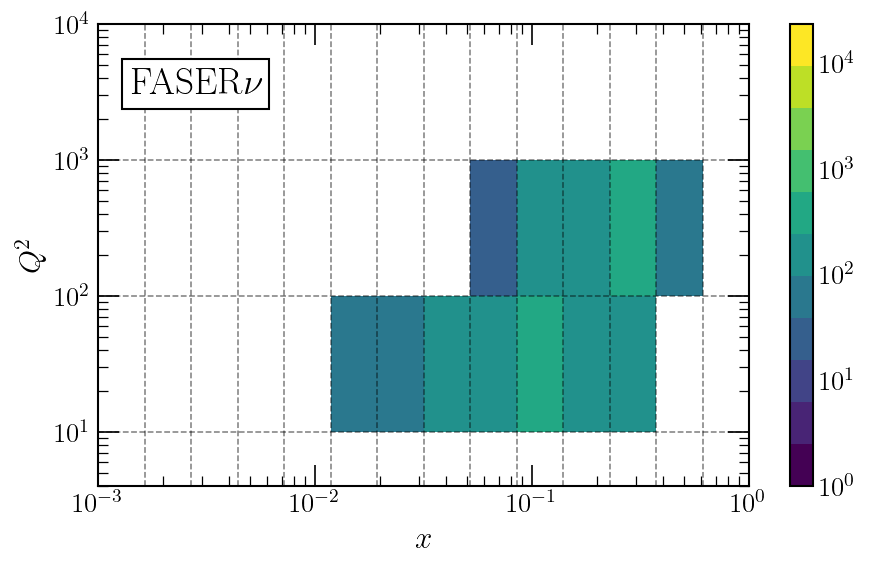

In [27]:
updated_separate_experiments(grouped_datasets, expname="FASERv", binning=15)

/tmp/ipykernel_13438/3011904922.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 11)


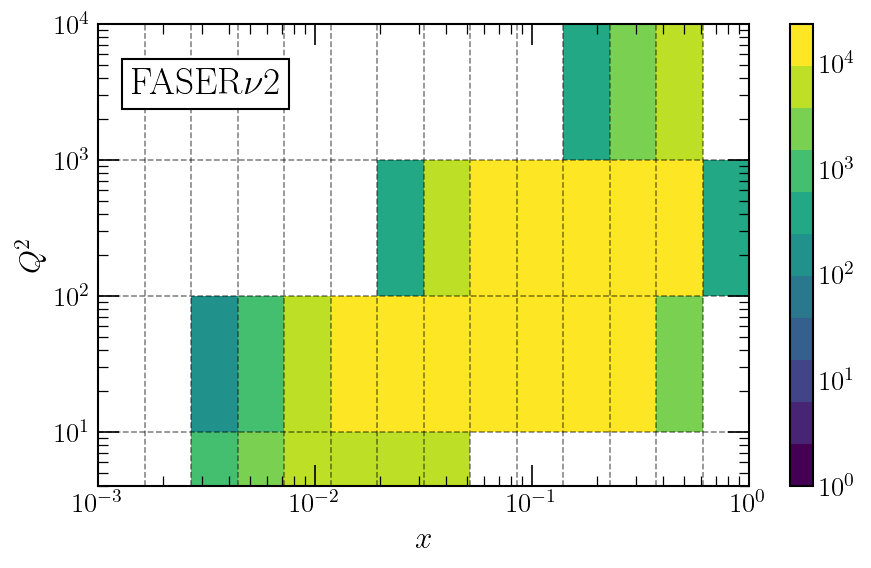

In [28]:
updated_separate_experiments(grouped_datasets, expname="FASERv2", binning=15)

/tmp/ipykernel_13438/3011904922.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 11)


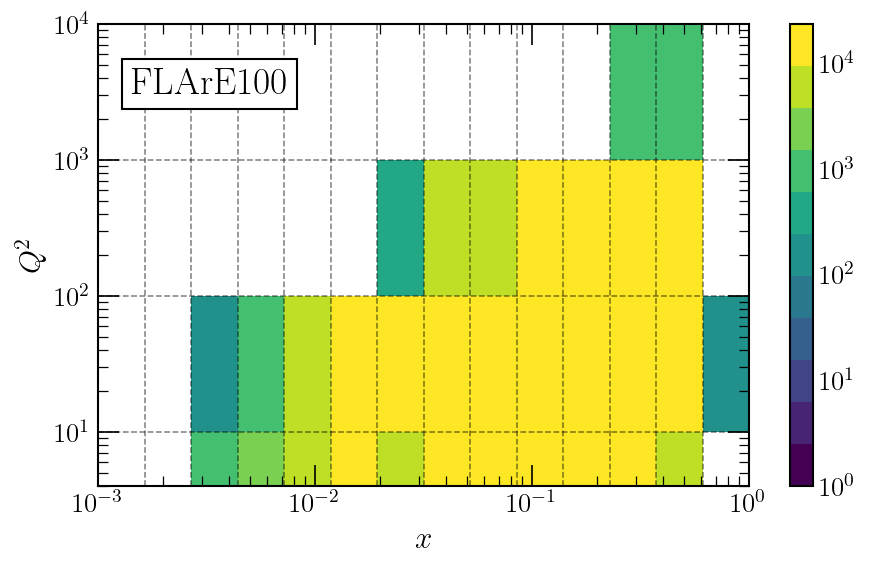

In [29]:
updated_separate_experiments(grouped_datasets, expname="FLArE100", binning=15)

/tmp/ipykernel_13438/3011904922.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 11)


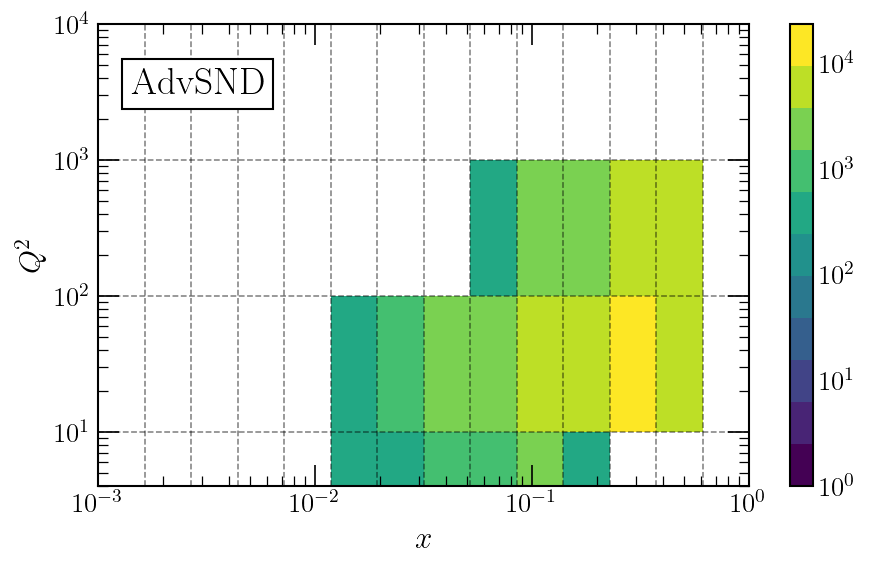

In [30]:
updated_separate_experiments(grouped_datasets, expname="AdvSND", binning=15)